In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

# 读文件

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float64
Cabin          91 non-null object
Embarked       418 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# 观察survived

In [6]:
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

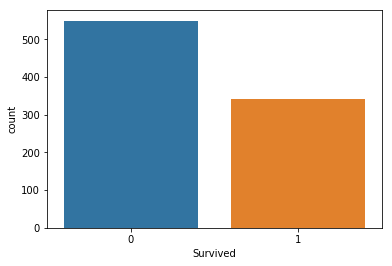

In [7]:
sns.countplot(train['Survived'])

# 观察pclass

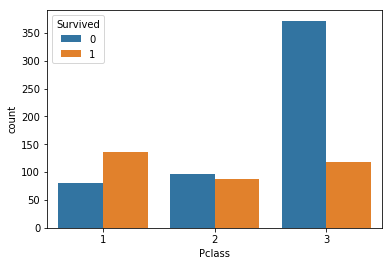

In [8]:
sns.countplot(train['Pclass'], hue=train['Survived'])

In [9]:
train['Survived'].groupby(train['Pclass']).mean()

Pclass
1    0.629630
2    0.472826
3    0.242363
Name: Survived, dtype: float64

# 观察name

In [10]:
train['name_title'] = train['Name'].apply(lambda x: x.split(',')[1] if len(x.split(',')) > 1 else x.split(',')[0]).apply(lambda x: x.split()[0])
train['name_title'].value_counts()

Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Mlle.          2
Col.           2
Don.           1
Mme.           1
Jonkheer.      1
Sir.           1
Capt.          1
Ms.            1
Lady.          1
the            1
Name: name_title, dtype: int64

In [11]:
test['name_title'] = test['Name'].apply(lambda x: x.split(',')[1] if len(x.split(',')) > 1 else x.split(',')[0]).apply(lambda x: x.split()[0])
test['name_title'].value_counts()


Mr.        240
Miss.       78
Mrs.        72
Master.     21
Rev.         2
Col.         2
Dr.          1
Dona.        1
Ms.          1
Name: name_title, dtype: int64

In [12]:
train['name_title'] = train['name_title'].replace('Mlle.', 'Miss.')
train['name_title'] = train['name_title'].replace('Ms.', 'Miss.')
train['name_title'] = train['name_title'].replace('Mme.', 'Mrs.')
test['name_title'] = test['name_title'].replace('Ms.', 'Miss.')

train['name_title'] = train['name_title'].replace(['Dr.', 'Col.', 'Don.', 'Jonkheer.', 'Capt.', 'Lady.', 'Major.', 'Sir.', 'the', 'Dona.', 'Rev.'], 'ignore')
test['name_title'] = test['name_title'].replace(['Dr.', 'Col.', 'Dona.', 'Rev.'], 'ignore')
train['Survived'].groupby(train['name_title']).mean()

name_title
Master.    0.575000
Miss.      0.702703
Mr.        0.156673
Mrs.       0.793651
ignore     0.347826
Name: Survived, dtype: float64

In [13]:
train['name_title'].value_counts()

Mr.        517
Miss.      185
Mrs.       126
Master.     40
ignore      23
Name: name_title, dtype: int64

In [14]:
test['name_title'].value_counts()

Mr.        240
Miss.       79
Mrs.        72
Master.     21
ignore       6
Name: name_title, dtype: int64

In [15]:
#train['name_title'] = train['name_title'].map({"Mr": 1, "Miss": 4, "Mrs": 5, "Master": 3, "ignore": 2})
#train['name_title'] = train['name_title'].fillna(0)

In [16]:
train['name_len'] = train['Name'].apply(lambda x: len(x))
test['name_len'] = test['Name'].apply(lambda x: len(x))

train['Survived'].groupby(pd.qcut(train['name_len'], 5)).mean()

name_len
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

In [17]:

train.loc[(train['name_len'] <= 19), 'name_len'] = 0
train.loc[(train['name_len'] > 19) & (train['name_len'] <= 23), 'name_len'] = 1
train.loc[(train['name_len'] > 23) & (train['name_len'] <= 27), 'name_len'] = 2
train.loc[(train['name_len'] > 27) & (train['name_len'] <= 32), 'name_len'] = 3
train.loc[(train['name_len'] > 32), 'name_len'] = 4


test.loc[(test['name_len'] <= 19), 'name_len'] = 0
test.loc[(test['name_len'] > 19) & (test['name_len'] <= 23), 'name_len'] = 1
test.loc[(test['name_len'] > 23) & (test['name_len'] <= 27), 'name_len'] = 2
test.loc[(test['name_len'] > 27) & (test['name_len'] <= 32), 'name_len'] = 3
test.loc[(test['name_len'] > 32), 'name_len'] = 4


# 观察sex 

In [18]:
train['Sex'].value_counts(normalize=True)
train['Survived'].groupby(train['Sex']).mean()
#train['Sex'] = train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
#test['Sex'] = test['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

Sex
female    0.742038
male      0.188908
Name: Survived, dtype: float64

# 观察SibSp和parch

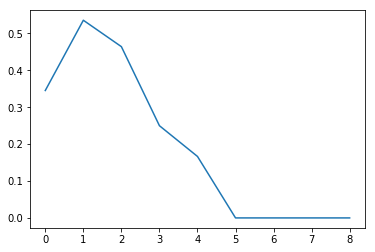

In [19]:
plt.plot(train['Survived'].groupby(train['SibSp']).mean())

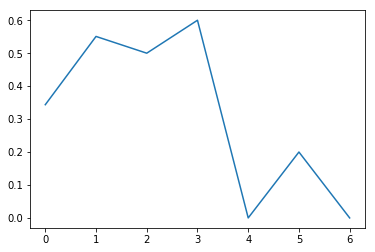

In [20]:
plt.plot(train['Survived'].groupby(train['Parch']).mean())

In [21]:
train['FamilySize'] = train['Parch'] + train['SibSp'] + 1

train.loc[(train['Parch'] > 1) & (train['name_title'] == 'Miss.'), 'is_mother'] = 1
train.loc[(train['Parch'] > 1) & (train['name_title'] == 'Mrs.'), 'is_mother'] = 1
train['is_mother'].fillna(0, inplace=True)

test.loc[(test['Parch'] > 1) & (test['name_title'] == 'Miss.'), 'is_mother'] = 1
test.loc[(test['Parch'] > 1) & (test['name_title'] == 'Mrs.'), 'is_mother'] = 1
test['is_mother'].fillna(0, inplace=True)

train['Singleton'] = train['FamilySize'].map(lambda s: 1 if s == 1 else 0)
train['SmallFamily'] = train['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
train['LargeFamily'] = train['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

test['FamilySize'] = test['Parch'] + test['SibSp'] + 1
test['Singleton'] = test['FamilySize'].map(lambda s: 1 if s == 1 else 0)
test['SmallFamily'] = test['FamilySize'].map(lambda s: 1 if 2 <= s <= 4 else 0)
test['LargeFamily'] = test['FamilySize'].map(lambda s: 1 if 5 <= s else 0)

# 观察ticket

In [22]:
def getTicketPrefix(ticket):
    match = re.compile("([a-zA-Z\.\/]+)").search(ticket)
    if match:
        return match.group()
    else:
        return 'U'

def getTicketNumber(ticket):
    match = re.compile("([\d]+$)").search(ticket)
    if match:
        return match.group()
    else:
        return '0'
    
    
train['TicketPrefix'] = train['Ticket'].map( lambda x : getTicketPrefix(x.upper()))
train['TicketPrefix'] = train['TicketPrefix'].map( lambda x: re.sub('[\.?\/?]', '', x) )
train['TicketPrefix'] = train['TicketPrefix'].map( lambda x: re.sub('STON', 'SOTON', x) ) 
train['TicketPrefixId'] = pd.factorize(train['TicketPrefix'])[0]
train.drop(['TicketPrefix'], axis=1, inplace=True)

test['TicketPrefix'] = test['Ticket'].map( lambda x : getTicketPrefix(x.upper()))
test['TicketPrefix'] = test['TicketPrefix'].map( lambda x: re.sub('[\.?\/?]', '', x) )
test['TicketPrefix'] = test['TicketPrefix'].map( lambda x: re.sub('STON', 'SOTON', x) ) 
test['TicketPrefixId'] = pd.factorize(test['TicketPrefix'])[0]
test.drop(['TicketPrefix'], axis=1, inplace=True)






train['TicketNumber'] = train['Ticket'].map( lambda x: getTicketNumber(x) )
train['TicketNumberDigits'] = train['TicketNumber'].map( lambda x: len(x) ).astype(np.int)
train['TicketNumberStart'] = train['TicketNumber'].map( lambda x: x[0:1] ).astype(np.int)
train['TicketNumber'] = train.TicketNumber.astype(np.int)

test['TicketNumber'] = test['Ticket'].map( lambda x: getTicketNumber(x) )
test['TicketNumberDigits'] = test['TicketNumber'].map( lambda x: len(x) ).astype(np.int)
test['TicketNumberStart'] = test['TicketNumber'].map( lambda x: x[0:1] ).astype(np.int)
test['TicketNumber'] = test.TicketNumber.astype(np.int)


# 观察cabin

In [23]:
train['Cabin'].fillna('U', inplace=True)
test['Cabin'].fillna('U', inplace=True)

In [24]:
def getNum(x):
    num = 0
    for i in range(len(x)):
        if x[i].isdigit():
            num = x[i:i+3]
            break
    return int(num)


In [25]:
train['cabin_num'] = train['Cabin'].apply(lambda x: getNum(str(x)))
test['cabin_num'] = test['Cabin'].apply(lambda x: getNum(str(x)))

In [26]:
train['Survived'].groupby(pd.qcut(train['cabin_num'],5, duplicates = 'drop')).mean()

cabin_num
(-0.001, 8.0]    0.313725
(8.0, 148.0]     0.666667
Name: Survived, dtype: float64

In [27]:
train.loc[(train['cabin_num'] <= 8), 'cabin_num'] = 0
train.loc[(train['cabin_num'] > 8), 'cabin_num'] = 1

test.loc[(test['cabin_num'] <= 8), 'cabin_num'] = 0
test.loc[(test['cabin_num'] > 8), 'cabin_num'] = 1

In [28]:
#train['Cabin'] = train['Cabin'].map(lambda x: 0 if type(x) == float else 1)
#test['Cabin'] = test['Cabin'].map(lambda x: 0 if type(x) == float else 1)


train['Cabin'] = train['Cabin'].apply(lambda x: x[0])
test['Cabin'] = test['Cabin'].apply(lambda x: x[0])

replacement = {
    'T': 0,
    'U': 1,
    'A': 2,
    'G': 3,
    'C': 4,
    'F': 5,
    'B': 6,
    'E': 7,
    'D': 8
}

train['Cabin'] = train['Cabin'].apply(lambda x: replacement.get(x))
test['Cabin'] = test['Cabin'].apply(lambda x: replacement.get(x))


# 观察fare

In [29]:
test.Fare.fillna(test.iloc[:891].Fare.mean(), inplace=True)

In [30]:
train['Survived'].groupby(pd.qcut(train['Fare'], 5)).mean()

Fare
(-0.001, 7.854]      0.217877
(7.854, 10.5]        0.201087
(10.5, 21.679]       0.424419
(21.679, 39.688]     0.444444
(39.688, 512.329]    0.642045
Name: Survived, dtype: float64

In [31]:
train.loc[(train['Fare'] <= 7.854), 'Fare'] = 1
train.loc[(train['Fare'] > 7.854) & (train['Fare'] <= 10.5), 'Fare'] = 0
train.loc[(train['Fare'] > 10.5) & (train['Fare'] <= 21.679), 'Fare'] = 2
train.loc[(train['Fare'] > 21.679) & (train['Fare'] <= 39.688), 'Fare'] = 3
train.loc[(train['Fare'] > 39.688), 'Fare'] = 4
train['Fare'] = train['Fare'].astype(int)


test.loc[(test['Fare'] <= 7.854), 'Fare'] = 1
test.loc[(test['Fare'] > 7.854) & (test['Fare'] <= 10.5), 'Fare'] = 0
test.loc[(test['Fare'] > 10.5) & (test['Fare'] <= 21.679), 'Fare'] = 2
test.loc[(test['Fare'] > 21.679) & (test['Fare'] <= 39.688), 'Fare'] = 3
test.loc[(test['Fare'] > 39.688), 'Fare'] = 4
test['Fare'] = test['Fare'].astype(int)

# 观察embarked

In [32]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [33]:
train['Survived'].groupby(train['Embarked']).mean()

Embarked
C    0.553571
Q    0.389610
S    0.336957
Name: Survived, dtype: float64

In [34]:
train['Embarked'] = train['Embarked'].fillna('S')
#train['Embarked'] = train['Embarked'].map( {'S': 1, 'C': 3, 'Q': 2} ).astype(int)

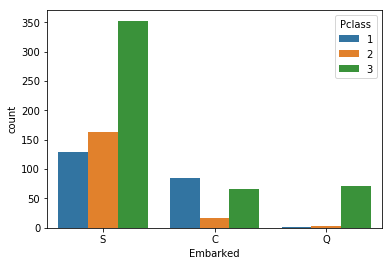

In [35]:
sns.countplot(train['Embarked'], hue=train['Pclass'])

# 观察age

In [36]:
train['age_flag'] = train['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
test['age_flag'] = test['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)

In [37]:

age_df = train[['Age', 'Fare', 'Parch', 'SibSp', 'is_mother', 'Singleton', 'Pclass']]
trainX = pd.DataFrame(age_df.loc[ (train.Age.notnull()) ].values[:, 1:])
trainy = pd.DataFrame(age_df.loc[ (train.Age.notnull()) ].values[:, 0])
rtr = RandomForestRegressor(n_estimators=50, random_state = 0, n_jobs=-1)
rtr.fit(trainX, trainy)
predictedAges = rtr.predict(age_df.loc[ (train.Age.isnull()) ].values[:, 1:])
train.loc[ (train.Age.isnull()), 'Age' ] = predictedAges 


age_df = test[['Age', 'Fare', 'Parch', 'SibSp', 'is_mother', 'Singleton', 'Pclass']]
testX = age_df.loc[(test.Age.notnull())].values[:, 1:]
testy = age_df.loc[(test.Age.notnull())].values[:, 0]  
rtr = RandomForestRegressor(n_estimators=2000, random_state = 0, n_jobs=-1)
rtr.fit(testX, testy)

predictedAges = rtr.predict(age_df.loc[ (test.Age.isnull()) ].values[:, 1:])
test.loc[ (test.Age.isnull()), 'Age' ] = predictedAges

#grouped_age = train.groupby(['name_title', 'Pclass'])['Age']
#train['Age'] = grouped_age.transform(lambda x: x.fillna(data['Age'].mean()) if pd.isnull(x.mean()) else x.fillna(x.mean()))

#grouped_age = test.groupby(['name_title', 'Pclass'])['Age']
#test['Age'] = grouped_age.transform(lambda x: x.fillna(test['Age'].mean()) if pd.isnull(x.mean()) else x.fillna(x.mean()))


In [38]:
train['Survived'].groupby(pd.qcut(train['Age'], 5, duplicates = 'drop')).mean()

Age
(0.419, 19.827]    0.458101
(19.827, 26.0]     0.324022
(26.0, 30.0]       0.318919
(30.0, 39.0]       0.450292
(39.0, 80.0]       0.372881
Name: Survived, dtype: float64

In [39]:
train.loc[(train['Age'] <= 19.867), 'Age_new'] = 4
train.loc[(train['Age'] > 19.867) & (train['Age'] <= 26), 'Age_new'] = 1
train.loc[(train['Age'] > 26) & (train['Age'] <= 30), 'Age_new'] = 0
train.loc[(train['Age'] > 30) & (train['Age'] <= 39), 'Age_new'] = 3
train.loc[(train['Age'] > 39), 'Age_new'] = 2


test.loc[(test['Age'] <= 19.867), 'Age_new'] = 4
test.loc[(test['Age'] > 19.867) & (test['Age'] <= 26), 'Age_new'] = 1
test.loc[(test['Age'] > 26) & (test['Age'] <= 30), 'Age_new'] = 0
test.loc[(test['Age'] > 30) & (test['Age'] <= 39), 'Age_new'] = 3
test.loc[(test['Age'] > 39), 'Age_new'] = 2


train['is_child'] = train['Age'].apply(lambda x: 1 if x < 18 else 0)
test['is_child'] = test['Age'].apply(lambda x: 1 if x < 18 else 0)

# drop列

In [40]:
train.drop(['Ticket','Name',], axis = 1, inplace = True)
test.drop(['Ticket','Name',], axis = 1, inplace = True)

# 转换dummy variable

In [41]:
def dummies(train, columns):
    for col in columns:
        train[col] = train[col].apply(lambda x: str(x))
        new_cols = [col + '_' + i for i in train[col].unique()]
        train = pd.concat([train, pd.get_dummies(train[col], prefix=col)[new_cols]], axis=1)
        del train[col]
    return train

train = dummies(train,['Sex', 'Embarked', 'Pclass', 'name_title'])
test = dummies(test, ['Sex', 'Embarked', 'Pclass', 'name_title'])

In [42]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()
train.Age = scaler.fit_transform(train.Age.reshape(-1,1))
test.Age = scaler.transform(test.Age.reshape(-1,1))

train.SibSp = scaler.fit_transform(train.SibSp.reshape(-1,1))
test.SibSp = scaler.transform(test.SibSp.reshape(-1,1))

train.Parch = scaler.fit_transform(train.Parch.reshape(-1,1))
test.Parch = scaler.transform(test.Parch.reshape(-1,1))

train.FamilySize = scaler.fit_transform(train.FamilySize.reshape(-1,1))
test.FamilySize = scaler.transform(test.FamilySize.reshape(-1,1))

train.TicketNumber = scaler.fit_transform(train.TicketNumber.reshape(-1,1))
test.TicketNumber = scaler.transform(test.TicketNumber.reshape(-1,1))

In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 33 columns):
PassengerId           418 non-null int64
Age                   418 non-null float64
SibSp                 418 non-null float64
Parch                 418 non-null float64
Fare                  418 non-null int64
Cabin                 418 non-null int64
name_len              418 non-null int64
is_mother             418 non-null float64
FamilySize            418 non-null float64
Singleton             418 non-null int64
SmallFamily           418 non-null int64
LargeFamily           418 non-null int64
TicketPrefixId        418 non-null int64
TicketNumber          418 non-null float64
TicketNumberDigits    418 non-null int64
TicketNumberStart     418 non-null int64
cabin_num             418 non-null int64
age_flag              418 non-null int64
Age_new               418 non-null float64
is_child              418 non-null int64
Sex_male              418 non-null uint8
Sex_female          

In [46]:
test.head()

,PassengerId,Age,SibSp,Parch,Fare,Cabin,name_len,is_mother,FamilySize,Singleton,...,Embarked_S,Embarked_C,Pclass_3,Pclass_2,Pclass_1,name_title_Mr.,name_title_Mrs.,name_title_Miss.,name_title_Master.,name_title_ignore
0,892,0.428248,0.000,0.000000,1,1,0,0.0,0.0,1,...,0,0,1,0,0,1,0,0,0,0
1,893,0.585323,0.125,0.000000,1,1,3,0.0,0.1,0,...,1,0,1,0,0,0,1,0,0,0
2,894,0.773813,0.000,0.000000,0,1,2,0.0,0.0,1,...,0,0,0,1,0,1,0,0,0,0
3,895,0.334004,0.000,0.000000,0,1,0,0.0,0.0,1,...,1,0,1,0,0,1,0,0,0,0
4,896,0.271174,0.125,0.166667,2,1,4,0.0,0.2,0,...,1,0,1,0,0,0,1,0,0,0


# 整合数据

In [43]:
label = train.iloc[:,1]
train = train.iloc[:,2:]
Id = test.iloc[:,0]
test = test.iloc[:,1:]

In [44]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

def measure_performance(X, y, clf, show_accuracy=True, show_classification_report=True, show_confussion_matrix=True):
    y_pred = clf.predict(X)
    if show_accuracy:
        print("Accuracy:{0:.3f}".format(metrics.accuracy_score(y, y_pred)),"\n")
    
    if show_classification_report:
        print("Classification report")
        print(metrics.classification_report(y, y_pred), "\n")
    
    if show_confussion_matrix:
        print("Confusion matrix")
        print(metrics.confusion_matrix(y, y_pred), "\n")
        
skb = SelectKBest(chi2, k=25)
train = skb.fit_transform(train, label)
test = skb.transform(test)


In [45]:

trainX, testX, trainY, testY = train_test_split(train, label, test_size=0.2, random_state=1)

# modeling

# Logistic Regression

In [410]:
from sklearn import linear_model
lr = linear_model.LogisticRegression(C=1e5, random_state=0)
parameters = {'C' : [.1, 1, 1e1,], 'solver' : ['lbfgs'], 
              'max_iter': [30, 40, 50], 'random_state': [0]}
lr_opt = GridSearchCV(lr, parameters, scoring = 'accuracy', cv = 5)
lr_opt.fit(trainX, trainY)
print(lr_opt.best_score_)
print(lr_opt.best_params_)

measure_performance(testX, testY, lr_opt.best_estimator_)

0.8384831460674157
{'C': 1, 'max_iter': 40, 'random_state': 0, 'solver': 'lbfgs'}
Accuracy:0.804 

Classification report
             precision    recall  f1-score   support

          0       0.82      0.86      0.84       106
          1       0.78      0.73      0.75        73

avg / total       0.80      0.80      0.80       179
 

Confusion matrix
[[91 15]
 [20 53]] 



# Random Forest

In [448]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
parameters = {'max_depth' : [4,5,6], 'n_estimators': [15], 'random_state': [0]}
rf_opt = GridSearchCV(rf, parameters, scoring = 'accuracy', cv = 5)
rf_opt.fit(trainX, trainY)

print(rf_opt.best_score_)
print(rf_opt.best_params_)

measure_performance(testX, testY, rf_opt.best_estimator_)

0.8426966292134831
{'max_depth': 5, 'n_estimators': 15, 'random_state': 0}
Accuracy:0.816 

Classification report
             precision    recall  f1-score   support

          0       0.81      0.91      0.85       106
          1       0.83      0.68      0.75        73

avg / total       0.82      0.82      0.81       179
 

Confusion matrix
[[96 10]
 [23 50]] 



# xgboost

In [413]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
parameters = {'max_depth' : [4], 'learning_rate': [0.1, .01, .001, 0.0001], 
              'n_estimators': [25, 50, 75], 'random_state': [0]}
xgb_opt = GridSearchCV(xgb, parameters, scoring = 'accuracy', cv = 5)
xgb_opt.fit(trainX, trainY)

print(xgb_opt.best_score_)
print(xgb_opt.best_params_)

measure_performance(testX, testY, xgb_opt.best_estimator_)

0.848314606741573
{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 50, 'random_state': 0}
Accuracy:0.799 

Classification report
             precision    recall  f1-score   support

          0       0.79      0.90      0.84       106
          1       0.81      0.66      0.73        73

avg / total       0.80      0.80      0.79       179
 

Confusion matrix
[[95 11]
 [25 48]] 



# AdaBoost

In [414]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
parameters = {'n_estimators': [25, 50, 75], 'learning_rate': [0.1, .01, .001, 0.0001], 'random_state': [0]}

ada_opt = GridSearchCV(ada, parameters, scoring = 'accuracy', cv = 5)
ada_opt.fit(trainX, trainY)

print(ada_opt.best_score_)
print(ada_opt.best_params_)

measure_performance(testX, testY, ada_opt.best_estimator_)

0.8160112359550562
{'learning_rate': 0.1, 'n_estimators': 75, 'random_state': 0}
Accuracy:0.799 

Classification report
             precision    recall  f1-score   support

          0       0.80      0.88      0.84       106
          1       0.79      0.68      0.74        73

avg / total       0.80      0.80      0.80       179
 

Confusion matrix
[[93 13]
 [23 50]] 



# GBDT

In [415]:
from sklearn.ensemble import GradientBoostingClassifier

gbdt = GradientBoostingClassifier()
parameters = {'loss' : ['deviance', 'exponential'],
              'n_estimators': [25, 50, 75], 
              'learning_rate': [ 0.1, .01, .001], 
              'max_depth': [5],
              'random_state': [0],}

gbdt_opt = GridSearchCV(gbdt, parameters, scoring = 'accuracy', cv = 5)
gbdt_opt.fit(trainX, trainY)

print(gbdt_opt.best_score_)
print(gbdt_opt.best_params_)

measure_performance(testX, testY, gbdt_opt.best_estimator_)


0.8370786516853933
{'learning_rate': 0.1, 'loss': 'exponential', 'max_depth': 5, 'n_estimators': 50, 'random_state': 0}
Accuracy:0.793 

Classification report
             precision    recall  f1-score   support

          0       0.79      0.89      0.84       106
          1       0.80      0.66      0.72        73

avg / total       0.79      0.79      0.79       179
 

Confusion matrix
[[94 12]
 [25 48]] 



# Extra Trees

In [416]:
from sklearn.ensemble import ExtraTreesClassifier

et = ExtraTreesClassifier()
parameters = {'criterion': ['entropy', 'gini'],
              'n_estimators': [30],
              'bootstrap': [True, False],
              'max_depth': [6],
              'min_samples_split': [2],
              'random_state': [0],}

et_opt = GridSearchCV(et, parameters, scoring = 'accuracy', cv = 5)
et_opt.fit(trainX, trainY)

print(et_opt.best_score_)
print(et_opt.best_params_)

measure_performance(testX, testY, et_opt.best_estimator_)

0.8441011235955056
{'bootstrap': True, 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 2, 'n_estimators': 30, 'random_state': 0}
Accuracy:0.799 

Classification report
             precision    recall  f1-score   support

          0       0.79      0.91      0.84       106
          1       0.82      0.64      0.72        73

avg / total       0.80      0.80      0.79       179
 

Confusion matrix
[[96 10]
 [26 47]] 



# Decision Tree

In [417]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier()

parameters = {'criterion': ['entropy', 'gini'],
              'max_depth': [2,3,4],
              'min_samples_split': [2, 3],
              'random_state': [0],
             }

dt_opt = GridSearchCV(dt, parameters, scoring = 'accuracy', cv = 5)
dt_opt.fit(trainX, trainY)

print(dt_opt.best_score_)
print(dt_opt.best_params_)

measure_performance(testX, testY, dt_opt.best_estimator_)


0.8188202247191011
{'criterion': 'entropy', 'max_depth': 4, 'min_samples_split': 2, 'random_state': 0}
Accuracy:0.804 

Classification report
             precision    recall  f1-score   support

          0       0.81      0.88      0.84       106
          1       0.80      0.70      0.74        73

avg / total       0.80      0.80      0.80       179
 

Confusion matrix
[[93 13]
 [22 51]] 



# SVM

In [418]:
from sklearn import svm
svm = svm.SVC()
parameters = {
              'random_state': [0],
             }

svm_opt = GridSearchCV(svm, parameters, scoring = 'accuracy', cv = 5)
svm_opt.fit(trainX, trainY)

print(svm_opt.best_score_)
print(svm_opt.best_params_)

measure_performance(testX, testY, svm_opt.best_estimator_)

0.8342696629213483
{'random_state': 0}
Accuracy:0.804 

Classification report
             precision    recall  f1-score   support

          0       0.81      0.87      0.84       106
          1       0.79      0.71      0.75        73

avg / total       0.80      0.80      0.80       179
 

Confusion matrix
[[92 14]
 [21 52]] 



# lightGBM

In [49]:
import lightgbm as lgb
params_opt = {
    'boosting': ['gbdt'],
    'tree_learner': ['voting'],
    'metric': ['binary_logloss'],
    'objective': ['binary'],   
    'n_estimators':[10, 25, 50, 75,100], 
    'learning_rate': [0.1, .01],
    'max_depth': [4],
}




lgbm = lgb.LGBMClassifier()

lgbm_opt = GridSearchCV(lgbm, params_opt, scoring = 'accuracy', cv = 5)
lgbm_opt.fit(trainX, trainY)

print(lgbm_opt.best_score_)
print(lgbm_opt.best_params_)

measure_performance(testX, testY, lgbm_opt.best_estimator_)

0.8497191011235955
{'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': 4, 'metric': 'binary_logloss', 'n_estimators': 25, 'objective': 'binary', 'tree_learner': 'voting'}
Accuracy:0.771 

Classification report
             precision    recall  f1-score   support

          0       0.77      0.88      0.82       106
          1       0.78      0.62      0.69        73

avg / total       0.77      0.77      0.77       179
 

Confusion matrix
[[93 13]
 [28 45]] 



# model voting

In [426]:
from sklearn.ensemble import VotingClassifier
vc =VotingClassifier(estimators=[('lr', lr_opt.best_estimator_), 
                                 ('rf', rf_opt.best_estimator_), 
                                 ('xgb', xgb_opt.best_estimator_), 
                                 ('ada', ada_opt.best_estimator_), 
                                 ('gbdt', gbdt_opt.best_estimator_), 
                                 ('et', et_opt.best_estimator_), 
                                 ('dt', dt_opt.best_estimator_),
                                 ('svm', svm_opt.best_estimator_),
                                 ('lgbm', lgbm_opt.best_estimator_),
                                ], 
                     voting='hard')

vc.fit(trainX, trainY)
measure_performance(testX, testY, vc)

Accuracy:0.816 

Classification report
             precision    recall  f1-score   support

          0       0.81      0.90      0.85       106
          1       0.82      0.70      0.76        73

avg / total       0.82      0.82      0.81       179
 

Confusion matrix
[[95 11]
 [22 51]] 



# submit result

In [441]:

pred = rf_opt.best_estimator_.predict(test)
Submission = pd.DataFrame({ 'PassengerId': Id,'Survived': pred })
Submission.to_csv("Submission.csv", index=False)